In [10]:
from heeps.util.img_processing import resize_cube
from heeps.util.multiCPU import multiCPU
import proper
import warnings
import numpy as np
from astropy.io import fits
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from matplotlib.pylab import ScalarFormatter
from matplotlib import cm
%matplotlib inline

In [2]:
pup = fits.getdata('/Users/cdelacroix/INSTRUMENTS/METIS/heeps_metis/input_files/wavefront/mask_Cbasic_20210504_720.fits')
pup = resize_cube(pup, 285)
pup[pup<.5]=0

(720, 720)


In [3]:
cube0 = fits.getdata('/Users/cdelacroix/INSTRUMENTS/METIS/heeps_metis/input_files/wavefront/cube_Cbasic_20210219_600s_100ms_0piston_meters_scao_only_285.fits')
cube1 = resize_cube(fits.getdata('/Users/cdelacroix/INSTRUMENTS/METIS/heeps_metis/input_files/wavefront/cube_Cbasic_20210504_600s_100ms_0piston_meters_scao_only_720_WV.fits'), 285)

In [12]:
nimg = 285
t_max = 600                         # cube duration in s
nzers = 20                          # number of Zernike modes to fit
ncube = 6000
pol_order = 3                       # filter polynomial order
win_size = 51                       # filter window size

In [13]:
def get_zpols(nzer, pup, phi):
    zpols = proper.prop_fit_zernikes(phi, pup, nimg/2, nzer, eps=0, fit=True)
    return zpols
zpols0 = multiCPU(get_zpols, posargs=[nzers, pup], posvars=[cube0[:ncube]], case='get zpols cube0')
zpols1 = multiCPU(get_zpols, posargs=[nzers, pup], posvars=[cube1[:ncube]], case='get zpols cube1')

   2021-05-20 16:53:00, get zpols cube0 using 12 cores
   2021-05-20 16:55:34, completed in 154.34 seconds
   2021-05-20 16:55:34, get zpols cube1 using 12 cores
   2021-05-20 16:59:11, completed in 216.91 seconds


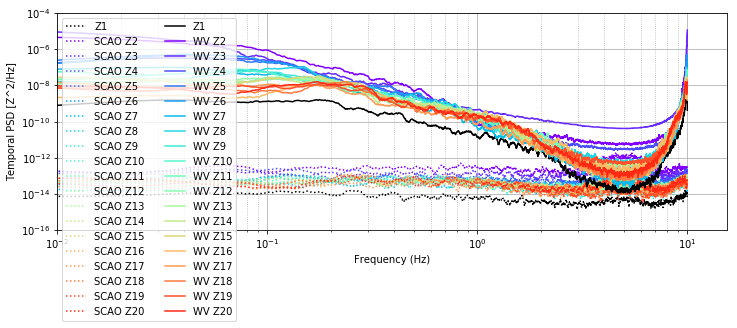

In [14]:
fs = np.arange(ncube)/t_max
Zf0 = np.abs(np.array([np.fft.fft(Zt) for Zt in zpols0.swapaxes(0,1)]))
Zf1 = np.abs(np.array([np.fft.fft(Zt) for Zt in zpols1.swapaxes(0,1)]))
plt.figure(figsize=(12,4))
plt.grid(True), plt.grid(which='minor', linestyle=':')
plt.loglog()
# Define the colors to be used using rainbow map (or any other map)
colors = np.array([cm.rainbow(i) for i in np.linspace(0, 1, len(Zf0))])
warnings.filterwarnings("ignore")
for i,z in enumerate(Zf0):
    zhat = savgol_filter(z, win_size, pol_order)
    if i==0:
        plt.plot(fs, zhat**2, ':k', label='Z%s'%(i+1))        
    else:
        plt.plot(fs, zhat**2, ':', color=colors[i-1], label='SCAO Z%s'%(i+1))
for i,z in enumerate(Zf1):
    zhat = savgol_filter(z, win_size, pol_order)
    if i==0:
        plt.plot(fs, zhat**2, 'k', label='Z%s'%(i+1))        
    else:
        plt.plot(fs, zhat**2, color=colors[i-1], label='WV Z%s'%(i+1))
plt.legend(ncol=2)
plt.xlim(left=1e-2)
plt.ylim((1e-16,1e-4))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Temporal PSD [Z^2/Hz]')
plt.savefig('SCAO_vs_WV_temp_psd_Z%s.png'%nzers, dpi=300, transparent=True)